# Определение возраста покупателей

## Описание данных.

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.<br>Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:<br>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;<br>
- Контролировать добросовестность кассиров при продаже алкоголя.

Наша задача - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим на размер выборки.

In [3]:
print(f"Размер выборки: {len(labels)}")

Размер выборки: 7591


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Построим график распределения возраста в выборке.

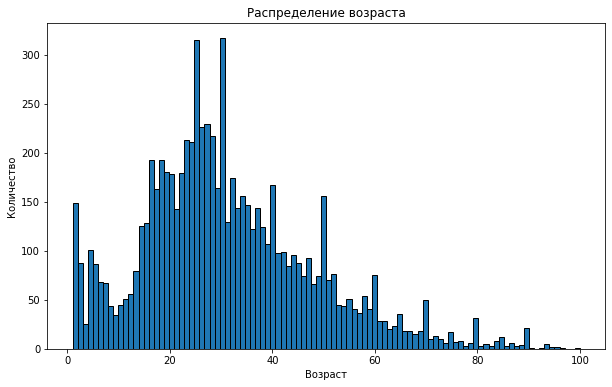

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

И теперь напечатаем на экране 10 фотографий и посмотрим, как устроен датасет.

Found 7591 validated image filenames.


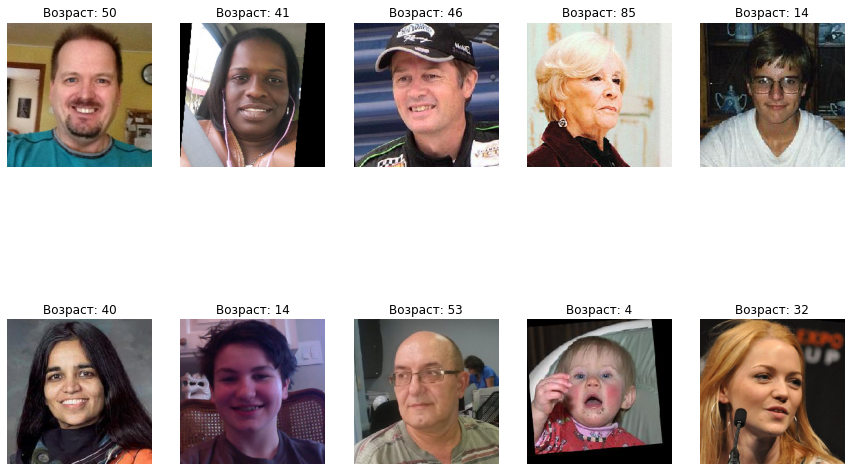

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

features, targets = next(train_gen_flow)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(features[i])
    plt.title(f"Возраст: {int(targets[i])}")
    plt.axis('off')
plt.show()

**Промежуточный вывод:**<br>Перед обучением модели стоит подвести итоги загрузки данных.<br>Датасет содержит 7591 изображение с возрастами от 1 до 100 лет, с концентрацией фотографий в возрасте от 20 до 40 лет. Наблюдается дисбаланс в распределении возрастов, особенно среди пожилых людей. Для улучшения устойчивости модели возможно придется применять аугментации, такие как горизонтальные перевороты, изменение яркости, масштабирование, сдвиги и вращение.<br>Наша цель - разработать модель для автоматического определения возраста клиентов супермаркета, что поможет в анализе покупок и контроле продажи алкоголя.

## Обучение модели

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2024-06-20 21:56:18.919265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-20 21:56:19.210431: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 192.5456 - mae: 10.1644 - val_loss: 561.9689 - val_mae: 18.4507
Epoch 2/10
356/356 - 40s - loss: 82.7397 - mae: 6.8975 - val_loss: 134.4544 - val_mae: 8.9830
Epoch 3/10
356/356 - 39s - loss: 58.5536 - mae: 5.8281 - val_loss: 84.6194 - val_mae: 6.8735
Epoch 4/10
356/356 - 40s - loss: 43.0884 - mae: 5.0438 - val_loss: 86.0325 - val_mae: 6.7649
Epoch 5/10
356/356 - 40s - loss: 32.8415 - mae: 4.3617 - val_loss: 65.9062 - val_mae: 6.0505
Epoch 6/10
356/356 - 40s - loss: 24.4820 - mae: 3.7645 - val_loss: 73.4859 - val_mae: 6.3849
Epoch 7/10
356/356 - 39s - loss: 21.7034 - mae: 3.5731 - val_loss: 92.0698 - val_mae: 7.2388
Epoch 8/10
356/356 - 40s - loss: 17.7512 - mae: 3.2058 - val_loss: 74.9975 - val_mae: 6.6413
Epoch 9/10
356/356 - 40s - loss: 15.0981 - mae: 2.9328 - val_loss: 70.8485 - val_mae: 6.2961
Epoch 10/10
356/356 - 40s - loss: 12.8670 - mae: 2.7376 - val_loss: 63.9458 - val_mae: 6.0102

119/119 - 10s - loss: 63.9458 - mae: 6.0102
Test MAE: 6.0102

```

## Анализ обученной модели

**Вывод:**<br>Проект подошел к концу, а значит стоит подвести итоги.<br>После ознакомоления и визуализации данных, мы поняли, что с ними все в порядке. Далее мы написали код, который загружает и обрабатывает набор данных изображений с метками возраста, создаёт свёрточную нейронную сеть на основе ResNet50, и обучает её для предсказания возраста людей по фотографиям.<br>Модель обучалась в течение 10 эпох. В процессе обучения ошибка предсказания возраста на тестовой выборке постепенно снижалась: в начале обучения MAE была 18.4507, а к концу обучения снизилась до 6.0102. Это показывает, что модель успешно обучилась распознавать возраст людей по фотографиям, достигнув приемлемого уровня ошибки.